In [1]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
edgelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv')
edgelist.head(10)

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0
5,o_rs,y_rs,rs,0.12,red,0
6,y_rs,rs_end_south,rs,0.39,red,0
7,rc_end_north,v_rc,rc,0.70,red,0
8,v_rc,b_rc,rc,0.04,red,0
9,b_rc,g_rc,rc,0.15,red,0


In [ ]:
nodelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv')
nodelist.head(10)

# I/ Create Graph

In [29]:
# Create empty graph
g = nx.Graph()

In [30]:
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    src, dst = elrow[0], elrow[1] 
    g.add_edge(src, dst, attr_dict=elrow[2:].to_dict())

In [31]:
# Add node attributes
for i, nlrow in nodelist.iterrows():
    g.nodes[nlrow['id']].update(nlrow[1:].to_dict())

In [32]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 123
# of nodes: 77


# II/ Visualize

**Position**: First you need to manipulate the node positions from the graph into a dictionary. This will allow you to recreate the graph using the same layout as the actual trail map. Y is negated to transform the Y-axis origin from the topleft to the bottomleft.

In [33]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

{'rs_end_north': (1772, -172),
 'v_rs': (1793, -484),
 'b_rs': (1747, -700),
 'g_rs': (1676, -775),
 'w_rs': (1646, -947)}

**Colors**: Now you manipulate the edge colors from the graph into a simple list so that you can visualize the trails by their color.

In [56]:
# Each trail has an associate color.

# Define data structure (list) of edge colors for plotting
edge_colors = [list(e[2].values())[0]['color'] for e in g.edges(data=True)]

# Preview first 10
edge_colors[0:10]

['red',
 'red',
 'violet',
 'violet',
 'red',
 'blue',
 'blue',
 'red',
 'green',
 'green']

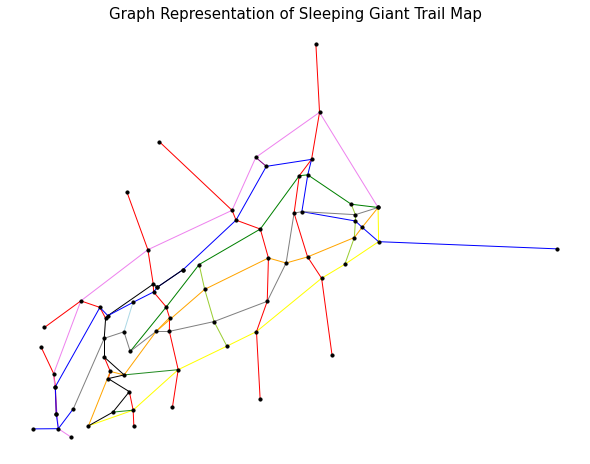

In [60]:
plt.figure(figsize=(8, 6))
nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black')
plt.title('Graph Representation of Sleeping Giant Trail Map', size=15)
plt.show()

# III/ CPP

## CPP Step 1: Find Nodes of Odd Degree

In [69]:
# Calculate list of nodes with odd degree
nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]

# Preview
nodes_odd_degree[0:5]

['rs_end_north',
 'rs_end_south',
 'rc_end_north',
 'rc_end_south',
 'rt_end_north']

In [71]:
# Counts
print('Number of nodes of odd degree: {}'.format(len(nodes_odd_degree)))
print('Number of total nodes: {}'.format(len(g.nodes())))

Number of nodes of odd degree: 36
Number of total nodes: 77


## CPP Step 2: Find Min Distance Pairs

1. Compute all possible pairs of odd degree nodes.

2. Compute the shortest path between each node pair calculated in **1.**

3. Create a complete graph connecting every node pair in 1. with shortest path distance attributes calculated in **2.**

4. Compute a minimum weight matching of the graph calculated in **3.** (This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).

5. Augment the original graph with the shortest paths between the node pairs calculated in **4.**

### Step 2.1: Compute Node Pairs


In [75]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

# Preview pairs of odd degree nodes
odd_node_pairs[0:10]

[('rs_end_north', 'rs_end_south'),
 ('rs_end_north', 'rc_end_north'),
 ('rs_end_north', 'rc_end_south'),
 ('rs_end_north', 'rt_end_north'),
 ('rs_end_north', 'o_rt'),
 ('rs_end_north', 'y_rt'),
 ('rs_end_north', 'rt_end_south'),
 ('rs_end_north', 'rh_end_north'),
 ('rs_end_north', 'rh_end_tt_1'),
 ('rs_end_north', 'rh_end_tt_2')]

In [76]:
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 630


### Step 2.2: Compute Shortest Paths between Node Pairs

In [77]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [78]:
# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{('rs_end_north', 'rs_end_south'): 7,
 ('rs_end_north', 'rc_end_north'): 4,
 ('rs_end_north', 'rc_end_south'): 8,
 ('rs_end_north', 'rt_end_north'): 5,
 ('rs_end_north', 'o_rt'): 7,
 ('rs_end_north', 'y_rt'): 9,
 ('rs_end_north', 'rt_end_south'): 10,
 ('rs_end_north', 'rh_end_north'): 6,
 ('rs_end_north', 'rh_end_tt_1'): 7,
 ('rs_end_north', 'rh_end_tt_2'): 9}

### Step 2.3: Create Complete Graph

In [79]:
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters:
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        g.add_edge(k[0], k[1], attr_dict={'distance': v, 'weight': wt_i})
    return g

In [80]:
# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 36
Number of edges: 630


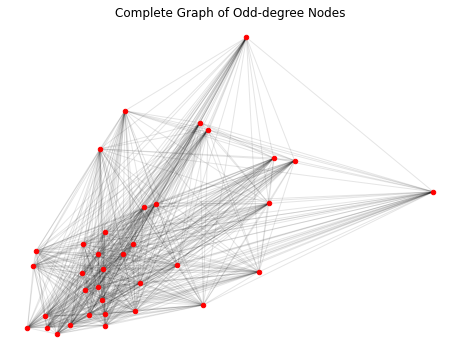

In [81]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

### Step 2.4: Compute Minimum Weight Matching


In [82]:
# Compute min weight matching.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)

print('Number of edges in matching: {}'.format(len(odd_matching_dupes)))

Number of edges in matching: 18


In [83]:
# Preview of matching with dupes
odd_matching_dupes

{('b_bv', 'rh_end_tt_3'),
 ('b_end_east', 'rh_end_tt_2'),
 ('b_end_west', 'rh_end_south'),
 ('b_v', 'v_end_west'),
 ('o_rt', 'g_gy2'),
 ('rc_end_north', 'y_gy1'),
 ('rc_end_south', 'o_tt'),
 ('rd_end_south', 'v_bv'),
 ('rh_end_north', 'g_w'),
 ('rh_end_tt_4', 'b_tt_3'),
 ('rs_end_north', 'nature_end_west'),
 ('rt_end_north', 'o_y_tt_end_west'),
 ('rt_end_south', 'o_w_1'),
 ('v_end_east', 'rd_end_north'),
 ('w_bw', 'rh_end_tt_1'),
 ('y_gy2', 'rs_end_south'),
 ('y_rh', 'b_bw'),
 ('y_rt', 'g_gy1')}

In [87]:
# Convert matching to list of deduped tuples
odd_matching = list(pd.unique([tuple(sorted([k, v])) for k, v in odd_matching_dupes]))

# Counts
print('Number of edges in matching (deduped): {}'.format(len(odd_matching)))

Number of edges in matching (deduped): 18


In [88]:
# Preview of deduped matching
odd_matching

[('b_bw', 'y_rh'),
 ('rc_end_north', 'y_gy1'),
 ('g_gy2', 'o_rt'),
 ('o_tt', 'rc_end_south'),
 ('o_y_tt_end_west', 'rt_end_north'),
 ('rd_end_north', 'v_end_east'),
 ('g_w', 'rh_end_north'),
 ('rh_end_tt_1', 'w_bw'),
 ('b_end_west', 'rh_end_south'),
 ('rd_end_south', 'v_bv'),
 ('g_gy1', 'y_rt'),
 ('b_v', 'v_end_west'),
 ('b_tt_3', 'rh_end_tt_4'),
 ('nature_end_west', 'rs_end_north'),
 ('o_w_1', 'rt_end_south'),
 ('b_bv', 'rh_end_tt_3'),
 ('b_end_east', 'rh_end_tt_2'),
 ('rs_end_south', 'y_gy2')]

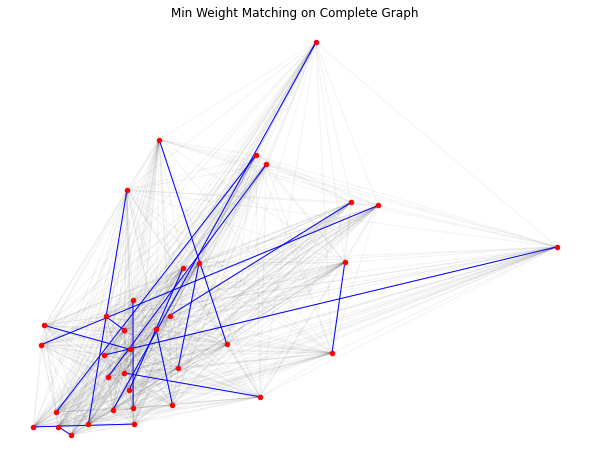

In [89]:
plt.figure(figsize=(8, 6))

# Plot the complete graph of odd-degree nodes
nx.draw(g_odd_complete, pos=node_positions, node_size=20, alpha=0.05)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Complete Graph')
plt.show()

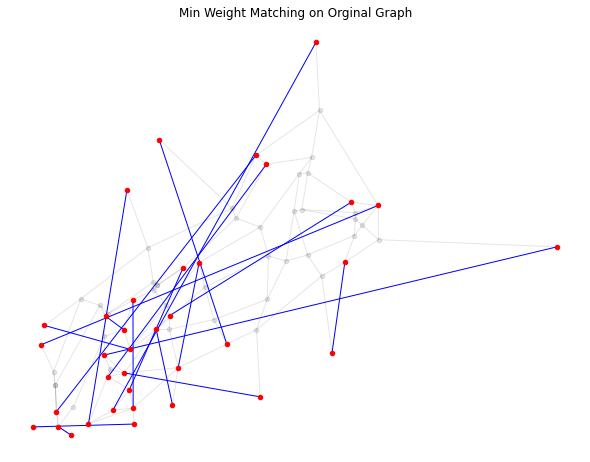

In [90]:
plt.figure(figsize=(8, 6))

# Plot the original trail map graph
nx.draw(g, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

### Step 2.5: Augment the Original Graph


In [91]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """

    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0],
                           pair[1],
                           attr_dict={'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]),
                                      'trail': 'augmented'}
                          )
    return graph_aug

In [92]:
# Create augmented graph: add the min weight matching edges to g
g_aug = add_augmenting_path_to_graph(g, odd_matching)

# Counts
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))

Number of edges in original graph: 123
Number of edges in augmented graph: 141


In [93]:
pd.value_counts(g_aug.degree())

(v_rt, 4)            1
(rh_end_tt_4, 4)     1
(rt_end_north, 2)    1
(b_tt_2, 4)          1
(b_bw, 4)            1
                    ..
(o_w_2, 4)           1
(b_rd, 4)            1
(b_rd_dupe, 2)       1
(b_rs, 4)            1
(w_tt, 4)            1
Length: 77, dtype: int64

## CPP Step 3: Compute Eulerian Circuit

### Naive Circuit

In [94]:
naive_euler_circuit = list(nx.eulerian_circuit(g_aug, source='b_end_east'))

In [96]:
print('Length of eulerian circuit: {}'.format(len(naive_euler_circuit)))

Length of eulerian circuit: 141


In [98]:
# Preview naive Euler circuit
naive_euler_circuit[0:10]

[('b_end_east', 'b_y'),
 ('b_y', 'park_east'),
 ('park_east', 'g_gy2'),
 ('g_gy2', 'w_gy2'),
 ('w_gy2', 'park_east'),
 ('park_east', 'b_o'),
 ('b_o', 'o_gy2'),
 ('o_gy2', 'y_gy2'),
 ('y_gy2', 'rs_end_south'),
 ('rs_end_south', 'y_rs')]

### Correct Circuit

In [119]:
def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))

    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    
        
        if list(edge_data[0].values())[0]['trail'] != 'augmented':
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]]
            euler_circuit.append((edge[0], edge[1], edge_att))
        else:
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))

            print('Filling in edges for augmented edge: {}'.format(edge))
            print('Augmenting path: {}'.format(' => '.join(aug_path)))
            print('Augmenting path pairs: {}\n'.format(aug_path_pairs))

            # If `edge` does not exist in original graph, find the shortest path between its nodes and
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))

    return euler_circuit

In [120]:
# Create the Eulerian circuit
euler_circuit = create_eulerian_circuit(g_aug, g, 'b_end_east')

Filling in edges for augmented edge: ('y_gy2', 'rs_end_south')
Augmenting path: y_gy2 => y_rs => rs_end_south
Augmenting path pairs: [('y_gy2', 'y_rs'), ('y_rs', 'rs_end_south')]

Filling in edges for augmented edge: ('y_rt', 'g_gy1')
Augmenting path: y_rt => w_rt => o_rt => g_rt => g_gy1
Augmenting path pairs: [('y_rt', 'w_rt'), ('w_rt', 'o_rt'), ('o_rt', 'g_rt'), ('g_rt', 'g_gy1')]

Filling in edges for augmented edge: ('rh_end_tt_3', 'b_bv')
Augmenting path: rh_end_tt_3 => o_tt => o_w_1 => o_gy1 => o_rc => g_rc => b_rc => b_bv
Augmenting path pairs: [('rh_end_tt_3', 'o_tt'), ('o_tt', 'o_w_1'), ('o_w_1', 'o_gy1'), ('o_gy1', 'o_rc'), ('o_rc', 'g_rc'), ('g_rc', 'b_rc'), ('b_rc', 'b_bv')]

Filling in edges for augmented edge: ('v_bv', 'rd_end_south')
Augmenting path: v_bv => v_rc => v_rt => v_rh => b_rh => b_rd => rd_end_south
Augmenting path pairs: [('v_bv', 'v_rc'), ('v_rc', 'v_rt'), ('v_rt', 'v_rh'), ('v_rh', 'b_rh'), ('b_rh', 'b_rd'), ('b_rd', 'rd_end_south')]

Filling in edges for 

In [121]:
print('Length of Eulerian circuit: {}'.format(len(euler_circuit)))


Length of Eulerian circuit: 227


In [122]:
for i, edge in enumerate(euler_circuit[0:20]):
    print(i, edge)

0 ('b_end_east', 'b_y', {'attr_dict': {'trail': 'b', 'distance': 1.32, 'color': 'blue', 'estimate': 0}})
1 ('b_y', 'park_east', {'attr_dict': {'trail': 'y', 'distance': 0.14, 'color': 'yellow', 'estimate': 0}})
2 ('park_east', 'g_gy2', {'attr_dict': {'trail': 'g', 'distance': 0.14, 'color': 'green', 'estimate': 0}})
3 ('g_gy2', 'w_gy2', {'attr_dict': {'trail': 'gy2', 'distance': 0.05, 'color': 'yellowgreen', 'estimate': 0}})
4 ('w_gy2', 'park_east', {'attr_dict': {'trail': 'w', 'distance': 0.12, 'color': 'gray', 'estimate': 0}})
5 ('park_east', 'b_o', {'attr_dict': {'trail': 'o', 'distance': 0.11, 'color': 'orange', 'estimate': 0}})
6 ('b_o', 'o_gy2', {'attr_dict': {'trail': 'o', 'distance': 0.06, 'color': 'orange', 'estimate': 0}})
7 ('o_gy2', 'y_gy2', {'attr_dict': {'trail': 'gy2', 'distance': 0.12, 'color': 'yellowgreen', 'estimate': 0}})
8 ('y_gy2', 'y_rs', {'attr_dict': {'trail': 'y', 'distance': 0.16, 'color': 'yellow', 'estimate': 0}})
9 ('y_rs', 'rs_end_south', {'attr_dict': {'